# Recurrent Neural Networks Models
In this notebook, we show an example of how RNNs can be used with darts.
If you are new to darts, we recommend you first follow the `darts-intro.ipynb` notebook.

In [1]:
!pip install -q darts
!pip install -q matplotlib

     |████████████████████████████████| 451 kB 13.2 MB/s 
     |████████████████████████████████| 43 kB 1.2 MB/s 
     |████████████████████████████████| 800 kB 62.2 MB/s 
     |████████████████████████████████| 76.6 MB 24 kB/s 
     |████████████████████████████████| 9.9 MB 30.7 MB/s 
     |████████████████████████████████| 575 kB 86.1 MB/s 
     |████████████████████████████████| 91 kB 11.4 MB/s 
     |████████████████████████████████| 1.9 MB 46.0 MB/s 
     |████████████████████████████████| 9.4 MB 50.3 MB/s 
     |████████████████████████████████| 1.6 MB 48.3 MB/s 
     |████████████████████████████████| 295 kB 84.7 MB/s 
     |████████████████████████████████| 965 kB 68.5 MB/s 
     |████████████████████████████████| 512 kB 80.5 MB/s 
     |████████████████████████████████| 125 kB 86.4 MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd /content/drive/MyDrive/Colab Notebooks/dacon/ddareung/

/content/drive/MyDrive/Colab Notebooks/dacon/ddareung


In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import shutil
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm_notebook as tqdm

from tensorboardX import SummaryWriter
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel, ExponentialSmoothing, BlockRNNModel
from darts.metrics import mape
from darts.utils.statistics import check_seasonality, plot_acf
from darts.datasets import AirPassengersDataset, SunspotsDataset
from darts.utils.timeseries_generation import datetime_attribute_timeseries

import warnings

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

In [6]:
import os
import random

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(42) # Seed 고정

## Recurrent Models

Darts includes two recurrent forecasting model classes: `RNNModel` and `BlockRNNModel`. 

`RNNModel` is fully recurrent in the sense that, at prediction time, an output is computed using these inputs:

- the previous target value, which will be set to the last known target value for the first prediction,
  and for all other predictions it will be set to the previous prediction
- the previous hidden state
- the current covariates (if the model was trained with covariates)

A prediction with forecasting horizon `n` thus is created in `n` iterations of `RNNModel` predictions and requires `n` future covariates to be known. This model is suited for forecasting problems where the target series is highly dependent on covariates that are known in advance.

`BlockRNNModel` has a recurrent encoder stage, which encodes its input, and a fully-connected neural network decoder stage, which produces a prediction of length `output_chunk_length` based on the last hidden state of the encoder stage. Consequently, this model produces 'blocks' of forecasts and is restricted to looking at covariates with the same time index as the input target series.

## Air Passenger Example
This is a data set that is highly dependent on covariates. Knowing the month tells us a lot about the seasonal component, whereas the year determines the effect of the trend component. Both of these covariates are known in the future, and thus the `RNNModel` class is the preferred choice for this problem.

In [ ]:
# import pandas as pd
# from datetime import datetime

# train = pd.read_csv('data/train.csv')
# temp_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dacon/따릉이/data/train_gwangjin.csv')

# temp_df['일시'] = temp_df.일시.apply(lambda x : datetime.strptime(str(x),'%Y%m%d'))
# temp_df.fillna(0, inplace=True)

# train['평균풍속'] = temp_df['평균 풍속(m/s)']
# train['평균기온'] = temp_df['평균기온(°C)']
# train['평균습도'] = temp_df['평균 상대습도(%)']
# train['최고최저기온평균'] = (temp_df['최고기온(°C)'] + temp_df['최저기온(°C)']) / 2
# train['불쾌지수'] = (1.8*train['최고최저기온평균'] - 0.558*(1-train['평균습도']/100)*(1.8*train['최고최저기온평균']-26) + 32) / 100

In [13]:
path = '/content/drive/MyDrive/Colab Notebooks/dacon/따릉이/'

In [64]:
import os

dong_df = pd.read_csv(path+'data/train_dongdaemoon.csv')
gwang_df = pd.read_csv(path+'data/train_gwangjin.csv')
jung_df = pd.read_csv(path+'data/train_jungnang.csv')
seong_df = pd.read_csv(path+'data/train_seongdong.csv')


def columns_reset(df, name):
  df.columns = ['일시', name, '승차총승객수', '하차총승객수', '평균기온', '최저기온', '최고기온',
                '강수 계속시간', '일강수량', '최대 풍속', '평균 풍속', '평균습도',
                '합계 3시간 신적설', '안개 계속시간', '따릉이대여소', '버스하차총승객수_sum',
                '버스하차총승객수_mean', '버스하차총승객수_size']


columns_reset(gwang_df, '광진구')
columns_reset(dong_df, '동대문구')
columns_reset(jung_df, '중랑구')
columns_reset(seong_df, '성동구')


gwang_df['요일'] = pd.to_datetime(gwang_df.일시.astype(str)).dt.day_name()
dong_df['요일'] = pd.to_datetime(dong_df.일시.astype(str)).dt.day_name()
jung_df['요일'] = pd.to_datetime(jung_df.일시.astype(str)).dt.day_name()
seong_df['요일'] = pd.to_datetime(seong_df.일시.astype(str)).dt.day_name()


gwang_day_rank = pd.DataFrame(gwang_df.groupby('요일')['광진구'].mean()).reset_index()
dong_day_rank = pd.DataFrame(dong_df.groupby('요일')['동대문구'].mean()).reset_index()
jung_day_rank = pd.DataFrame(jung_df.groupby('요일')['중랑구'].mean()).reset_index()
seong_day_rank = pd.DataFrame(seong_df.groupby('요일')['성동구'].mean()).reset_index()


gwang_day_rank.columns = ['요일', '요일_rank']
dong_day_rank.columns = ['요일', '요일_rank']
jung_day_rank.columns = ['요일', '요일_rank']
seong_day_rank.columns = ['요일', '요일_rank']


gwang_df = pd.merge(gwang_df, gwang_day_rank, how='left', on='요일').drop(['합계 3시간 신적설', '안개 계속시간', '요일'], axis=1)
dong_df = pd.merge(dong_df, dong_day_rank, how='left', on='요일').drop(['합계 3시간 신적설', '안개 계속시간', '요일'], axis=1)
jung_df = pd.merge(jung_df, jung_day_rank, how='left', on='요일').drop(['합계 3시간 신적설', '안개 계속시간', '요일'], axis=1)
seong_df = pd.merge(seong_df, seong_day_rank, how='left', on='요일').drop(['합계 3시간 신적설', '안개 계속시간', '요일'], axis=1)


gwang_df['최고최저기온평균'] = (gwang_df['최고기온'] + gwang_df['최저기온']) / 2
gwang_df['불쾌지수'] = (1.8*gwang_df['최고최저기온평균'] - 0.558*(1-gwang_df['평균습도']/100)*(1.8*gwang_df['최고최저기온평균']-26) + 32) / 100
gwang_df['체감온도'] = 13.12 + (0.6215*gwang_df['평균기온']) - 11.37*(gwang_df['평균 풍속']**0.16) + 0.3965*(gwang_df['평균 풍속']**0.16)*gwang_df['평균기온']

dong_df['최고최저기온평균'] = (dong_df['최고기온'] + dong_df['최저기온']) / 2
dong_df['불쾌지수'] = (1.8*dong_df['최고최저기온평균'] - 0.558*(1-dong_df['평균습도']/100)*(1.8*dong_df['최고최저기온평균']-26) + 32) / 100
dong_df['체감온도'] = 13.12 + (0.6215*dong_df['평균기온']) - 11.37*(dong_df['평균 풍속']**0.16) + 0.3965*(dong_df['평균 풍속']**0.16)*dong_df['평균기온']

jung_df['최고최저기온평균'] = (jung_df['최고기온'] + jung_df['최저기온']) / 2
jung_df['불쾌지수'] = (1.8*jung_df['최고최저기온평균'] - 0.558*(1-jung_df['평균습도']/100)*(1.8*jung_df['최고최저기온평균']-26) + 32) / 100
jung_df['체감온도'] = 13.12 + (0.6215*jung_df['평균기온']) - 11.37*(jung_df['평균 풍속']**0.16) + 0.3965*(jung_df['평균 풍속']**0.16)*jung_df['평균기온']

seong_df['최고최저기온평균'] = (seong_df['최고기온'] + seong_df['최저기온']) / 2
seong_df['불쾌지수'] = (1.8*seong_df['최고최저기온평균'] - 0.558*(1-seong_df['평균습도']/100)*(1.8*seong_df['최고최저기온평균']-26) + 32) / 100
seong_df['체감온도'] = 13.12 + (0.6215*seong_df['평균기온']) - 11.37*(seong_df['평균 풍속']**0.16) + 0.3965*(seong_df['평균 풍속']**0.16)*seong_df['평균기온']


gwang_df['월'] = pd.to_datetime(gwang_df.일시.astype(str)).dt.month_name()
dong_df['월'] = pd.to_datetime(dong_df.일시.astype(str)).dt.month_name()
jung_df['월'] = pd.to_datetime(jung_df.일시.astype(str)).dt.month_name()
seong_df['월'] = pd.to_datetime(seong_df.일시.astype(str)).dt.month_name()


gwang_month_rank = pd.DataFrame(gwang_df.groupby('월')['광진구'].mean()).reset_index()
dong_month_rank = pd.DataFrame(dong_df.groupby('월')['동대문구'].mean()).reset_index()
jung_month_rank = pd.DataFrame(jung_df.groupby('월')['중랑구'].mean()).reset_index()
seong_month_rank = pd.DataFrame(seong_df.groupby('월')['성동구'].mean()).reset_index()


gwang_month_rank.columns = ['월','month_rank']
dong_month_rank.columns = ['월','month_rank']
jung_month_rank.columns = ['월','month_rank']
seong_month_rank.columns = ['월','month_rank']


gwang_df = pd.merge(gwang_df, gwang_month_rank, how='left', on='월').drop(['월'],axis=1)
dong_df = pd.merge(dong_df, dong_month_rank, how='left', on='월').drop(['월'],axis=1)
jung_df = pd.merge(jung_df, jung_month_rank, how='left', on='월').drop(['월'],axis=1)
seong_df = pd.merge(seong_df, seong_month_rank, how='left', on='월').drop(['월'],axis=1)

In [93]:
from darts import TimeSeries
from datetime import datetime

# Read a pandas DataFrame
#df = pd.read_csv('/content/drive/MyDrive/따릉이/data/train.csv')
df = seong_df
df['일시'] = df.일시.apply(lambda x : datetime.strptime(str(x),'%Y%m%d'))
# Create a TimeSeries, specifying the time and value columns
series = TimeSeries.from_dataframe(df, "일시", ['성동구', '평균기온', '평균 풍속', '버스하차총승객수_size', '체감온도', '요일_rank', '하차총승객수', '불쾌지수', 'month_rank'])

# Set aside the last 36 months as a validation series
#train, val = series[:1096], series[1096:]


# Normalize the time series (note: we avoid fitting the transformer on the validation set)
transformer = Scaler()
#train_transformed = transformer.fit_transform(train)
#val_transformed = transformer.transform(val)
series_transformed = transformer.fit_transform(series)

# create month and year covariate series
year_series = datetime_attribute_timeseries(
    pd.date_range(start=series.start_time(), freq=series.freq_str, periods=1461+334),
    attribute="year",
    cyclic=False,
)
year_series = Scaler().fit_transform(year_series)
quarter_series = datetime_attribute_timeseries(
    year_series, attribute="quarter", one_hot=True
)
month_series = datetime_attribute_timeseries(
    year_series, attribute="month", one_hot=True
)
week_series = datetime_attribute_timeseries(
    year_series, attribute="week_of_year", cyclic=True
)

covariates = year_series.stack(quarter_series)
covariates = covariates.stack(month_series)
covariates = covariates.stack(week_series)

#cov_train, cov_val = covariates.split_after(pd.Timestamp("2020-12-31"))

Let's train an LSTM neural net. For using vanilla RNN or GRU instead, replace `'LSTM'` by `'RNN'` or `'GRU'`, respectively.

In [94]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

early_stopper = EarlyStopping("train_loss", min_delta=0.0001, patience=10, verbose=True)
callbacks = [early_stopper]
pl_trainer_kwargs = {"callbacks": callbacks}

my_model = RNNModel(
    model="LSTM", #이부분 수정시 GRU, RNN 사용 가능 
    hidden_dim=20,
    n_rnn_layers=2,
    dropout=0,
    batch_size=16,
    n_epochs=200,
    optimizer_kwargs={"lr": 1e-3},
    model_name="LSTM_1212_성동구",
    log_tensorboard=True,
    random_state=42,
    training_length=37,
    input_chunk_length=7,
    force_reset=True,
    save_checkpoints=True,
    loss_fn=torch.nn.L1Loss(),
    pl_trainer_kwargs=pl_trainer_kwargs,
    )

In what follows, we can just provide the whole `covariates` series as `future_covariates` argument to the model; the model will slice these covariates and use only what it needs in order to train on forecasting the target `train_transformed`:

In [95]:
my_model.fit(
    series_transformed,
    future_covariates=covariates,
    #val_series=val_transformed,
    #val_future_covariates=covariates,
    verbose=True,
)

Training: 0it [00:00, ?it/s]

### Look at predictions on the validation set
Use the "current" model - i.e., the model at the end of the training procedure:

In [ ]:
# def eval_model(model):
#     pred_series = model.predict(n=699, future_covariates=covariates)
#     plt.figure(figsize=(8, 5))
#     series_transformed.plot(label="actual")
#     pred_series.plot(label="forecast")
#     plt.title("MAPE: {:.2f}%".format(mape(pred_series, val_transformed)))
#     plt.legend()
    
# eval_model(my_model)

In [75]:
best_model_g = RNNModel.load_from_checkpoint(model_name="LSTM_1212_광진구", best=False)
# eval_model(best_model_g)
#pred_series = best_model_g.predict(n=699, future_covariates=covariates)
#mape(pred_series, val_transformed)

In [81]:
best_model_d = RNNModel.load_from_checkpoint(model_name="LSTM_1212_동대문구", best=False)
# eval_model(best_model_d)
# pred_series = best_model_d.predict(n=699, future_covariates=covariates)
# mape(pred_series, val_transformed)

In [90]:
best_model_j = RNNModel.load_from_checkpoint(model_name="LSTM_1212_중랑구", best=False)
# eval_model(best_model_j)
# pred_series = best_model_j.predict(n=699, future_covariates=covariates)
# mape(pred_series, val_transformed)

In [96]:
best_model_s = RNNModel.load_from_checkpoint(model_name="LSTM_1212_성동구", best=False)
# eval_model(best_model_s)
# pred_series = best_model_s.predict(n=699, future_covariates=covariates)
# mape(pred_series, val_transformed)

In [76]:
ff_g = best_model_g.predict(n=334, future_covariates=covariates)# predict
ff_g = transformer.inverse_transform(ff_g) #역 정규화
last_pred_g = ff_g#[365:699]#2022년1월1일 2022년 11월30일
last_pred_g = last_pred_g.pd_dataframe() # 데이터프레임 변환
last_pred_g = last_pred_g.applymap(lambda x: 0 if x < 0 else x).reset_index() # -값 0으로 치환

Predicting: 0it [00:00, ?it/s]

In [77]:
last_pred_g['광진구'].describe()

count    334.000000
mean      11.410712
std        3.189010
min        2.793846
25%       10.075342
50%       11.745584
75%       13.378333
max       17.172241
Name: 광진구, dtype: float64

In [84]:
ff_d = best_model_d.predict(n=334, future_covariates=covariates)# predict
ff_d = transformer.inverse_transform(ff_d) #역 정규화
last_pred_d = ff_d#[365:699]#2022년1월1일 2022년 11월30일
last_pred_d = last_pred_d.pd_dataframe() # 데이터프레임 변환
last_pred_d = last_pred_d.applymap(lambda x: 0 if x < 0 else x).reset_index() # -값 0으로 치환

Predicting: 0it [00:00, ?it/s]

In [85]:
last_pred_d['동대문구'].describe()

count    334.000000
mean       8.678001
std        1.994041
min        2.985819
25%        7.812391
50%        9.239637
75%       10.200712
max       11.768200
Name: 동대문구, dtype: float64

In [91]:
ff_j = best_model_j.predict(n=334, future_covariates=covariates)# predict
ff_j = transformer.inverse_transform(ff_j) #역 정규화
last_pred_j = ff_j#[365:699]#2022년1월1일 2022년 11월30일
last_pred_j = last_pred_j.pd_dataframe() # 데이터프레임 변환
last_pred_j = last_pred_j.applymap(lambda x: 0 if x < 0 else x).reset_index() # -값 0으로 치환

Predicting: 0it [00:00, ?it/s]

In [92]:
last_pred_j['중랑구'].describe()

count    334.000000
mean       6.613465
std        1.558551
min        2.181043
25%        6.061691
50%        7.215995
75%        7.633588
max        8.833975
Name: 중랑구, dtype: float64

In [98]:
ff_s = best_model_s.predict(n=334, future_covariates=covariates)# predict
ff_s = transformer.inverse_transform(ff_s) #역 정규화
last_pred_s = ff_s#[365:699]#2022년1월1일 2022년 11월30일
last_pred_s = last_pred_s.pd_dataframe() # 데이터프레임 변환
last_pred_s = last_pred_s.applymap(lambda x: 0 if x < 0 else x).reset_index() # -값 0으로 치환

Predicting: 0it [00:00, ?it/s]

In [99]:
last_pred_s['성동구'].describe()

count    334.000000
mean       9.197384
std        2.552721
min        2.184352
25%        8.382586
50%       10.125661
75%       11.116340
max       12.462804
Name: 성동구, dtype: float64

In [100]:
submit = pd.read_csv('data/sample_submission.csv')

submit['광진구'] = last_pred_g.광진구
submit['동대문구'] = last_pred_d.동대문구
submit['성동구'] = last_pred_s.성동구
submit['중랑구'] = last_pred_j.중랑구

submit = submit.set_index('일시')

In [101]:
submit

,광진구,동대문구,성동구,중랑구
일시,,,,
20220101,2.793846,2.985819,2.184352,2.181043
20220102,3.553927,3.539309,2.634871,2.562190
20220103,4.393978,4.259463,3.516446,2.861091
20220104,4.614863,3.953604,3.258451,2.914938
20220105,5.117150,4.399405,3.328430,2.993862
...,...,...,...,...
20221126,8.872395,6.206059,7.821939,5.929435
20221127,9.591237,6.284081,7.122092,5.964722
20221128,9.695093,7.347265,7.947880,5.510000


In [102]:
submit['광진구'].min(), submit['광진구'].max(), submit['광진구'].mean()

(2.7938461735165556, 17.172241071183844, 11.410711657087413)

In [103]:
submit['동대문구'].min(), submit['동대문구'].max(), submit['동대문구'].mean()

(2.985818671795969, 11.768199586908825, 8.678001159159773)

In [104]:
submit['성동구'].min(), submit['성동구'].max(), submit['성동구'].mean()

(2.1843522525385084, 12.462803796178097, 9.197384137170856)

In [105]:
submit['중랑구'].min(), submit['중랑구'].max(), submit['중랑구'].mean()

(2.181043190781646, 8.833974689404547, 6.6134648553354785)

In [106]:
submit['광진구'].plot()

ImportError: ignored

<Figure size 432x288 with 1 Axes>

<AxesSubplot: xlabel='일시'>

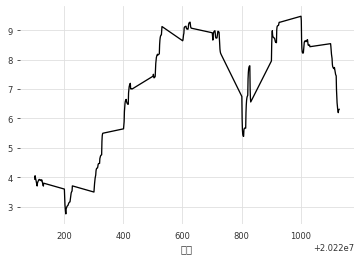

In [ ]:
submit['동대문구'].plot()

<AxesSubplot: xlabel='일시'>

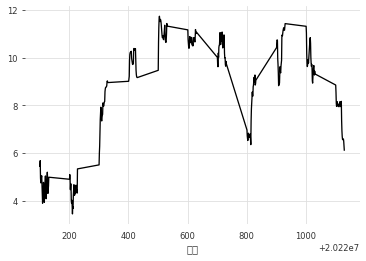

In [ ]:
submit['성동구'].plot()

<AxesSubplot: xlabel='일시'>

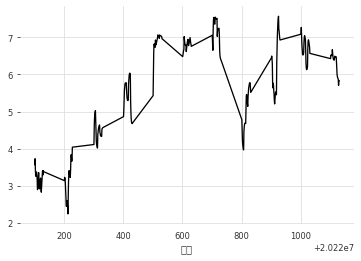

In [ ]:
submit['중랑구'].plot()

In [107]:
submit.to_csv('/content/drive/MyDrive/Colab Notebooks/dacon/ddareung/submission/1212_LSTM.csv')

In [ ]:
import os
import pandas as pd
from datetime import datetime
from darts.models.forecasting import transformer_model

def eval_model(model, past_covariates, series_transformed, val_transformed):
    pred_series = model.predict(n=699, past_covariates=past_covariates)
    plt.figure(figsize=(8, 5))
    series_transformed.plot(label="actual")
    pred_series.plot(label="forecast")
    plt.title("MAPE: {:.2f}%".format(mape(pred_series, val_transformed)))
    plt.legend()

file_list = os.listdir('/content/drive/MyDrive/Colab Notebooks/dacon/따릉이/data')
train_file_list = [file for file in file_list if file.startswith('train')]

jung_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dacon/따릉이/data/'+train_file_list[2])
seong_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dacon/따릉이/data/'+train_file_list[3])
gwang_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dacon/따릉이/data/'+train_file_list[1])
dong_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dacon/따릉이/data/'+train_file_list[0])

train = pd.read_csv('data/train.csv')

gwang_df['일시'] = gwang_df.일시.apply(lambda x : datetime.strptime(str(x), '%Y%m%d'))
dong_df['일시'] = dong_df.일시.apply(lambda x : datetime.strptime(str(x), '%Y%m%d'))
seong_df['일시'] = seong_df.일시.apply(lambda x : datetime.strptime(str(x), '%Y%m%d'))
jung_df['일시'] = jung_df.일시.apply(lambda x : datetime.strptime(str(x), '%Y%m%d'))

gwang_df.fillna(0, inplace=True)
dong_df.fillna(0, inplace=True)
seong_df.fillna(0, inplace=True)
jung_df.fillna(0, inplace=True)

train1 = train
train2 = train
train3 = train
train4 = train

train1['평균풍속'] = gwang_df['평균 풍속(m/s)']
train1['평균기온'] = gwang_df['평균기온(°C)']
train2['평균풍속'] = dong_df['평균 풍속(m/s)']
train2['평균기온'] = dong_df['평균기온(°C)']
train3['평균풍속'] = seong_df['평균 풍속(m/s)']
train3['평균기온'] = seong_df['평균기온(°C)']
train4['평균풍속'] = jung_df['평균 풍속(m/s)']
train4['평균기온'] = jung_df['평균기온(°C)']

train1 = train[['일시', '광진구', '평균풍속', '평균기온']]
train2 = train[['일시', '동대문구', '평균풍속', '평균기온']]
train3 = train[['일시', '성동구', '평균풍속', '평균기온']]
train4 = train[['일시', '중랑구', '평균풍속', '평균기온']]

df1 = train1
df2 = train2
df3 = train3
df4 = train4

df1['일시'] = df1.일시.apply(lambda x : datetime.strptime(str(x),'%Y%m%d'))
df2['일시'] = df2.일시.apply(lambda x : datetime.strptime(str(x),'%Y%m%d'))
df3['일시'] = df3.일시.apply(lambda x : datetime.strptime(str(x),'%Y%m%d'))
df4['일시'] = df4.일시.apply(lambda x : datetime.strptime(str(x),'%Y%m%d'))

# Create a TimeSeries, specifying the time and value columns
series1 = TimeSeries.from_dataframe(df1, "일시", ["광진구", '평균풍속', '평균기온'])
series2 = TimeSeries.from_dataframe(df2, "일시", ["동대문구", '평균풍속', '평균기온'])
series3 = TimeSeries.from_dataframe(df3, "일시", ["성동구", '평균풍속', '평균기온'])
series4 = TimeSeries.from_dataframe(df4, "일시", ["중랑구", '평균풍속', '평균기온'])

# Set aside the last 36 months as a validation series
train1, val1 = series1[:1096], series1[1096:]
train2, val2 = series2[:1096], series2[1096:]
train3, val3 = series3[:1096], series3[1096:]
train4, val4 = series4[:1096], series4[1096:]

# Normalize the time series (note: we avoid fitting the transformer on the validation set)
transformer1 = Scaler()
transformer2 = Scaler()
transformer3 = Scaler()
transformer4 = Scaler()

train_transformed1 = transformer1.fit_transform(train1)
val_transformed1 = transformer1.transform(val1)
series_transformed1 = transformer1.transform(series1)

train_transformed2 = transformer2.fit_transform(train2)
val_transformed2 = transformer2.transform(val2)
series_transformed2 = transformer2.transform(series2)

train_transformed3 = transformer3.fit_transform(train3)
val_transformed3 = transformer3.transform(val3)
series_transformed3 = transformer3.transform(series3)

train_transformed4 = transformer4.fit_transform(train4)
val_transformed4 = transformer4.transform(val4)
series_transformed4 = transformer4.transform(series4)

# create month and year covariate series
year_series1 = datetime_attribute_timeseries(
    pd.date_range(start=series1.start_time(), freq=series1.freq_str, periods=1461+334),
    attribute="year",
    one_hot=False,
)
year_series1 = Scaler().fit_transform(year_series1)
month_series1 = datetime_attribute_timeseries(
    year_series1, attribute="month", cyclic=True
)
covariates1 = year_series1.stack(month_series1)
cov_train1, cov_val1 = covariates1.split_after(pd.Timestamp("2020-12-31"))

year_series2 = datetime_attribute_timeseries(
    pd.date_range(start=series2.start_time(), freq=series2.freq_str, periods=1461+334),
    attribute="year",
    one_hot=False,
)
year_series2 = Scaler().fit_transform(year_series2)
month_series2 = datetime_attribute_timeseries(
    year_series2, attribute="month", cyclic=True
)
covariates2 = year_series2.stack(month_series2)
cov_train2, cov_val2 = covariates2.split_after(pd.Timestamp("2020-12-31"))

year_series3 = datetime_attribute_timeseries(
    pd.date_range(start=series3.start_time(), freq=series3.freq_str, periods=1461+334),
    attribute="year",
    one_hot=False,
)
year_series3 = Scaler().fit_transform(year_series3)
month_series3 = datetime_attribute_timeseries(
    year_series3, attribute="month", cyclic=True
)
covariates3 = year_series3.stack(month_series3)
cov_train3, cov_val3 = covariates3.split_after(pd.Timestamp("2020-12-31"))

year_series4 = datetime_attribute_timeseries(
    pd.date_range(start=series4.start_time(), freq=series4.freq_str, periods=1461+334),
    attribute="year",
    one_hot=False,
)
year_series4 = Scaler().fit_transform(year_series4)
month_series4 = datetime_attribute_timeseries(
    year_series4, attribute="month", cyclic=True
)
covariates4 = year_series4.stack(month_series4)
cov_train4, cov_val4 = covariates4.split_after(pd.Timestamp("2020-12-31"))

best_model1 = transformer_model.TransformerModel.load_from_checkpoint(model_name="LSTM_1_wind_tem_dis_gwangjin", best=True) # 23.11
eval_model(best_model1, covariates1, series_transformed1, val_transformed1)

best_model2 = transformer_model.TransformerModel.load_from_checkpoint(model_name="LSTM_1_wind_tem_dis_dongdaemoon", best=True) # 25.13
eval_model(best_model2, covariates2, series_transformed2, val_transformed2)

best_model3 = transformer_model.TransformerModel.load_from_checkpoint(model_name="LSTM_1_wind_tem_dis_seongdong", best=True) # 23.73
eval_model(best_model3, covariates3, series_transformed3, val_transformed3)

best_model4 = transformer_model.TransformerModel.load_from_checkpoint(model_name="LSTM_1_wind_tem_dis_jungnang", best=True) # 23.90
eval_model(best_model4, covariates4, series_transformed4, val_transformed4)

ff1 = best_model1.predict(n=699, past_covariates=covariates1) # predict
ff1 = transformer1.inverse_transform(ff1) # 역 정규화
ff2 = best_model2.predict(n=699, past_covariates=covariates2) # predict
ff2 = transformer2.inverse_transform(ff2) # 역 정규화
ff3 = best_model3.predict(n=699, past_covariates=covariates3) # predict
ff3 = transformer3.inverse_transform(ff3) # 역 정규화
ff4 = best_model4.predict(n=699, past_covariates=covariates4) # predict
ff4 = transformer4.inverse_transform(ff4) # 역 정규화

last_pred1 = ff1[365:699] # 2022년1월1일 2022년 11월30일
last_pred1 = last_pred1.pd_dataframe() # 데이터프레임 변환
last_pred1 = last_pred1.applymap(lambda x : 0 if x < 0 else x).reset_index() # -값 0으로 치환

last_pred2 = ff2[365:699] # 2022년1월1일 2022년 11월30일
last_pred2 = last_pred2.pd_dataframe() # 데이터프레임 변환
last_pred2 = last_pred2.applymap(lambda x : 0 if x < 0 else x).reset_index() # -값 0으로 치환

last_pred3 = ff3[365:699] # 2022년1월1일 2022년 11월30일
last_pred3 = last_pred3.pd_dataframe() # 데이터프레임 변환
last_pred3 = last_pred3.applymap(lambda x : 0 if x < 0 else x).reset_index() # -값 0으로 치환

last_pred4 = ff4[365:699] # 2022년1월1일 2022년 11월30일
last_pred4 = last_pred4.pd_dataframe() # 데이터프레임 변환
last_pred4 = last_pred4.applymap(lambda x : 0 if x < 0 else x).reset_index() # -값 0으로 치환

In [ ]:
submit = pd.read_csv('data/sample_submission.csv')

submit['광진구'] = last_pred1.광진구
submit['동대문구'] = last_pred2.동대문구
submit['성동구'] = last_pred3.성동구
submit['중랑구'] = last_pred4.중랑구

submit = submit.set_index('일시')

In [ ]:
submit

,일시,광진구,동대문구,성동구,중랑구
0,20220101,4.557939,0,0,0
1,20220102,4.541914,0,0,0
2,20220103,4.565943,0,0,0
3,20220104,4.558925,0,0,0
4,20220105,4.542937,0,0,0
...,...,...,...,...,...
329,20221126,7.528357,0,0,0
330,20221127,7.521501,0,0,0
331,20221128,7.515454,0,0,0
332,20221129,7.510128,0,0,0


<AxesSubplot: >

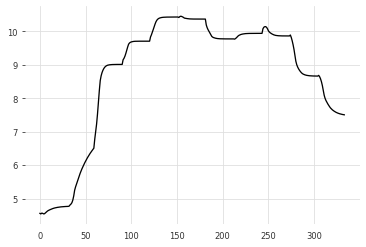

In [ ]:
submit['광진구'].plot()

<AxesSubplot: >

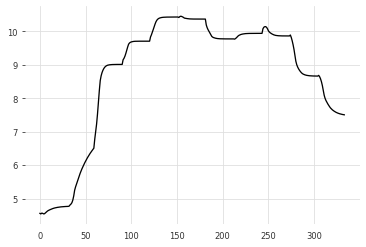

In [ ]:
submit['광진구'].plot()

In [ ]:
submit.to_csv('/content/drive/MyDrive/따릉이/data/submit_test.csv')

Use the best model obtained over training, according to validation loss:

### Backtesting
Let's backtest our `RNN` model, to see how it performs at a forecast horizon of 6 months:

In [ ]:
backtest_series = my_model.historical_forecasts(
    series_transformed,
    future_covariates=covariates,
    start=pd.Timestamp("20210101"),
    forecast_horizon=6,
    retrain=False,
    verbose=True,
)

  0%|          | 0/360 [00:00<?, ?it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

  1%|          | 2/360 [00:00<00:34, 10.28it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

  1%|          | 4/360 [00:00<00:33, 10.69it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

  2%|▏         | 6/360 [00:00<00:33, 10.68it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

  2%|▏         | 8/360 [00:00<00:33, 10.53it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

  3%|▎         | 10/360 [00:00<00:33, 10.55it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

  3%|▎         | 12/360 [00:01<00:32, 10.70it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

  4%|▍         | 14/360 [00:01<00:31, 11.04it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

  4%|▍         | 16/360 [00:01<00:31, 10.94it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

  5%|▌         | 18/360 [00:01<00:31, 11.03it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

  6%|▌         | 20/360 [00:01<00:31, 10.88it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

  6%|▌         | 22/360 [00:02<00:30, 11.26it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

  7%|▋         | 24/360 [00:02<00:30, 10.93it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

  7%|▋         | 26/360 [00:02<00:30, 11.00it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

  8%|▊         | 28/360 [00:02<00:30, 10.84it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

  8%|▊         | 30/360 [00:02<00:30, 10.97it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

  9%|▉         | 32/360 [00:02<00:29, 11.18it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

  9%|▉         | 34/360 [00:03<00:29, 11.16it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 10%|█         | 36/360 [00:03<00:28, 11.26it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 11%|█         | 38/360 [00:03<00:29, 10.96it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 11%|█         | 40/360 [00:03<00:28, 11.10it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 12%|█▏        | 42/360 [00:03<00:28, 11.26it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 12%|█▏        | 44/360 [00:03<00:27, 11.32it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 13%|█▎        | 46/360 [00:04<00:27, 11.39it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 13%|█▎        | 48/360 [00:04<00:27, 11.54it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 14%|█▍        | 50/360 [00:04<00:26, 11.51it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 14%|█▍        | 52/360 [00:04<00:27, 11.36it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 15%|█▌        | 54/360 [00:04<00:26, 11.48it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 16%|█▌        | 56/360 [00:05<00:27, 11.21it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 16%|█▌        | 58/360 [00:05<00:27, 11.10it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 17%|█▋        | 60/360 [00:05<00:26, 11.19it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 17%|█▋        | 62/360 [00:05<00:27, 11.02it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 18%|█▊        | 64/360 [00:05<00:26, 11.11it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 18%|█▊        | 66/360 [00:05<00:26, 11.18it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 19%|█▉        | 68/360 [00:06<00:25, 11.43it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 19%|█▉        | 70/360 [00:06<00:24, 11.66it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 20%|██        | 72/360 [00:06<00:23, 12.09it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 21%|██        | 74/360 [00:06<00:22, 12.85it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 21%|██        | 76/360 [00:06<00:22, 12.61it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 22%|██▏       | 78/360 [00:06<00:21, 13.12it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 22%|██▏       | 80/360 [00:07<00:20, 13.45it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 23%|██▎       | 82/360 [00:07<00:20, 13.67it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 23%|██▎       | 84/360 [00:07<00:20, 13.77it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 24%|██▍       | 86/360 [00:07<00:20, 13.64it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 24%|██▍       | 88/360 [00:07<00:19, 13.69it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 25%|██▌       | 90/360 [00:07<00:19, 13.71it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 26%|██▌       | 92/360 [00:07<00:18, 14.19it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 26%|██▌       | 94/360 [00:08<00:19, 13.68it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 27%|██▋       | 96/360 [00:08<00:19, 13.60it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 27%|██▋       | 98/360 [00:08<00:19, 13.72it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 28%|██▊       | 100/360 [00:08<00:19, 13.52it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 28%|██▊       | 102/360 [00:08<00:18, 13.78it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 29%|██▉       | 104/360 [00:08<00:19, 13.34it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 29%|██▉       | 106/360 [00:08<00:18, 13.70it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 30%|███       | 108/360 [00:09<00:18, 13.69it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 31%|███       | 110/360 [00:09<00:18, 13.83it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 31%|███       | 112/360 [00:09<00:18, 13.50it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 32%|███▏      | 114/360 [00:09<00:18, 13.32it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 32%|███▏      | 116/360 [00:09<00:18, 13.49it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 33%|███▎      | 118/360 [00:09<00:17, 13.66it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 33%|███▎      | 120/360 [00:09<00:17, 13.78it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 34%|███▍      | 122/360 [00:10<00:17, 13.77it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 34%|███▍      | 124/360 [00:10<00:17, 13.55it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 35%|███▌      | 126/360 [00:10<00:17, 13.46it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 36%|███▌      | 128/360 [00:10<00:17, 13.45it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 36%|███▌      | 130/360 [00:10<00:17, 13.22it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 37%|███▋      | 132/360 [00:11<00:25,  8.82it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 37%|███▋      | 134/360 [00:11<00:23,  9.82it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 38%|███▊      | 136/360 [00:11<00:20, 10.68it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 38%|███▊      | 138/360 [00:11<00:19, 11.40it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 39%|███▉      | 140/360 [00:11<00:18, 11.93it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 39%|███▉      | 142/360 [00:11<00:17, 12.78it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 40%|████      | 144/360 [00:11<00:17, 12.61it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 41%|████      | 146/360 [00:12<00:16, 12.81it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 41%|████      | 148/360 [00:12<00:16, 12.90it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 42%|████▏     | 150/360 [00:12<00:16, 13.10it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 42%|████▏     | 152/360 [00:12<00:16, 12.84it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 43%|████▎     | 154/360 [00:12<00:15, 13.03it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 43%|████▎     | 156/360 [00:12<00:15, 12.99it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 44%|████▍     | 158/360 [00:13<00:15, 12.99it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 44%|████▍     | 160/360 [00:13<00:15, 13.26it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 45%|████▌     | 162/360 [00:13<00:15, 13.09it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 46%|████▌     | 164/360 [00:13<00:15, 12.68it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 46%|████▌     | 166/360 [00:13<00:15, 12.86it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 47%|████▋     | 168/360 [00:13<00:15, 12.68it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 47%|████▋     | 170/360 [00:13<00:14, 12.70it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 48%|████▊     | 172/360 [00:14<00:14, 12.80it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 48%|████▊     | 174/360 [00:14<00:14, 12.59it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 49%|████▉     | 176/360 [00:14<00:14, 12.90it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 49%|████▉     | 178/360 [00:14<00:14, 12.68it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 50%|█████     | 180/360 [00:14<00:13, 12.98it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 51%|█████     | 182/360 [00:14<00:13, 12.79it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 51%|█████     | 184/360 [00:15<00:14, 12.51it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 52%|█████▏    | 186/360 [00:15<00:13, 12.67it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 52%|█████▏    | 188/360 [00:15<00:13, 12.83it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 53%|█████▎    | 190/360 [00:15<00:13, 12.84it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 53%|█████▎    | 192/360 [00:15<00:12, 13.06it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 54%|█████▍    | 194/360 [00:15<00:12, 13.09it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 54%|█████▍    | 196/360 [00:16<00:12, 13.03it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 55%|█████▌    | 198/360 [00:16<00:12, 13.22it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 56%|█████▌    | 200/360 [00:16<00:12, 12.96it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 56%|█████▌    | 202/360 [00:16<00:12, 13.05it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 57%|█████▋    | 204/360 [00:16<00:11, 13.09it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 57%|█████▋    | 206/360 [00:16<00:11, 13.06it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 58%|█████▊    | 208/360 [00:16<00:11, 12.68it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 58%|█████▊    | 210/360 [00:17<00:11, 13.09it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 59%|█████▉    | 212/360 [00:17<00:11, 13.24it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 59%|█████▉    | 214/360 [00:17<00:10, 13.29it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 60%|██████    | 216/360 [00:17<00:10, 13.49it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 61%|██████    | 218/360 [00:17<00:10, 13.62it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 61%|██████    | 220/360 [00:17<00:11, 12.68it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 62%|██████▏   | 222/360 [00:17<00:10, 13.05it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 62%|██████▏   | 224/360 [00:18<00:10, 13.02it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 63%|██████▎   | 226/360 [00:18<00:10, 12.95it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 63%|██████▎   | 228/360 [00:18<00:10, 13.17it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 64%|██████▍   | 230/360 [00:18<00:09, 13.48it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 64%|██████▍   | 232/360 [00:18<00:09, 13.27it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 65%|██████▌   | 234/360 [00:18<00:09, 13.14it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 66%|██████▌   | 236/360 [00:19<00:09, 12.81it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 66%|██████▌   | 238/360 [00:19<00:09, 12.57it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 67%|██████▋   | 240/360 [00:19<00:09, 12.65it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 67%|██████▋   | 242/360 [00:19<00:09, 12.99it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 68%|██████▊   | 244/360 [00:19<00:08, 13.15it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 68%|██████▊   | 246/360 [00:19<00:08, 13.18it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 69%|██████▉   | 248/360 [00:19<00:08, 12.87it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 69%|██████▉   | 250/360 [00:20<00:08, 13.03it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 70%|███████   | 252/360 [00:20<00:08, 12.85it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 71%|███████   | 254/360 [00:20<00:08, 12.84it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 71%|███████   | 256/360 [00:20<00:08, 12.60it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 72%|███████▏  | 258/360 [00:20<00:08, 12.65it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 72%|███████▏  | 260/360 [00:20<00:07, 12.53it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 73%|███████▎  | 262/360 [00:21<00:07, 12.69it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 73%|███████▎  | 264/360 [00:21<00:07, 12.43it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 74%|███████▍  | 266/360 [00:21<00:07, 12.55it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 74%|███████▍  | 268/360 [00:21<00:07, 12.52it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 75%|███████▌  | 270/360 [00:21<00:07, 12.37it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 76%|███████▌  | 272/360 [00:21<00:07, 12.55it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 76%|███████▌  | 274/360 [00:22<00:06, 12.51it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 77%|███████▋  | 276/360 [00:22<00:06, 12.67it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 77%|███████▋  | 278/360 [00:22<00:06, 12.81it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 78%|███████▊  | 280/360 [00:22<00:06, 12.56it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 78%|███████▊  | 282/360 [00:22<00:05, 13.09it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 79%|███████▉  | 284/360 [00:22<00:05, 12.85it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 79%|███████▉  | 286/360 [00:23<00:05, 12.51it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 80%|████████  | 288/360 [00:23<00:05, 12.69it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 81%|████████  | 290/360 [00:23<00:05, 12.70it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 81%|████████  | 292/360 [00:23<00:05, 12.55it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 82%|████████▏ | 294/360 [00:23<00:05, 12.90it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 82%|████████▏ | 296/360 [00:23<00:04, 12.99it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 83%|████████▎ | 298/360 [00:23<00:04, 13.02it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 83%|████████▎ | 300/360 [00:24<00:04, 13.35it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 84%|████████▍ | 302/360 [00:24<00:04, 12.92it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 84%|████████▍ | 304/360 [00:24<00:04, 12.98it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 85%|████████▌ | 306/360 [00:24<00:04, 13.00it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 86%|████████▌ | 308/360 [00:24<00:03, 13.25it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 86%|████████▌ | 310/360 [00:24<00:03, 13.43it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 87%|████████▋ | 312/360 [00:24<00:03, 13.68it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 87%|████████▋ | 314/360 [00:25<00:03, 13.46it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 88%|████████▊ | 316/360 [00:25<00:03, 13.42it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 88%|████████▊ | 318/360 [00:25<00:03, 13.59it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 89%|████████▉ | 320/360 [00:25<00:03, 13.31it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 89%|████████▉ | 322/360 [00:25<00:02, 13.14it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 90%|█████████ | 324/360 [00:25<00:02, 12.87it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 91%|█████████ | 326/360 [00:26<00:02, 13.05it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 91%|█████████ | 328/360 [00:26<00:02, 13.54it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 92%|█████████▏| 330/360 [00:26<00:02, 13.60it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 92%|█████████▏| 332/360 [00:26<00:02, 13.59it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 93%|█████████▎| 334/360 [00:26<00:01, 13.51it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 93%|█████████▎| 336/360 [00:26<00:01, 13.50it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 94%|█████████▍| 338/360 [00:26<00:01, 13.25it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 94%|█████████▍| 340/360 [00:27<00:01, 12.91it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 95%|█████████▌| 342/360 [00:27<00:01, 12.95it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 96%|█████████▌| 344/360 [00:27<00:01, 12.68it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 96%|█████████▌| 346/360 [00:27<00:01, 12.69it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 97%|█████████▋| 348/360 [00:27<00:00, 12.96it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 97%|█████████▋| 350/360 [00:27<00:00, 12.89it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 98%|█████████▊| 352/360 [00:28<00:00, 12.86it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 98%|█████████▊| 354/360 [00:28<00:00, 12.70it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 99%|█████████▉| 356/360 [00:28<00:00, 12.44it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 99%|█████████▉| 358/360 [00:28<00:00, 12.55it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

100%|██████████| 360/360 [00:28<00:00, 12.56it/s]


ValueError: ignored

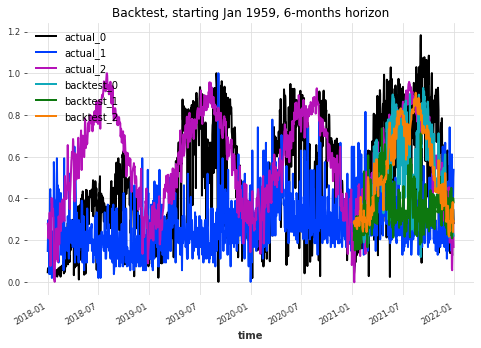

In [ ]:
plt.figure(figsize=(8, 5))
series_transformed.plot(label="actual")
backtest_series.plot(label="backtest")
plt.legend()
plt.title("Backtest, starting Jan 1959, 6-months horizon")
print(
    "MAPE: {:.2f}%".format(
        mape(
            transformer.inverse_transform(series_transformed),
            transformer.inverse_transform(backtest_series),
        )
    )
)

## Monthly sunspots
Let's now try a more challenging time series; that of the monthly number of sunspots since 1749. First, we build the time series from the data, and check its periodicity.

(True, 125)

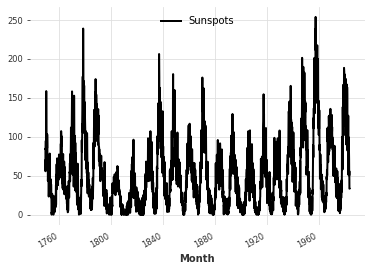

In [ ]:
# series_sunspot = SunspotsDataset().load()

# series_sunspot.plot()
# check_seasonality(series_sunspot, max_lag=240)

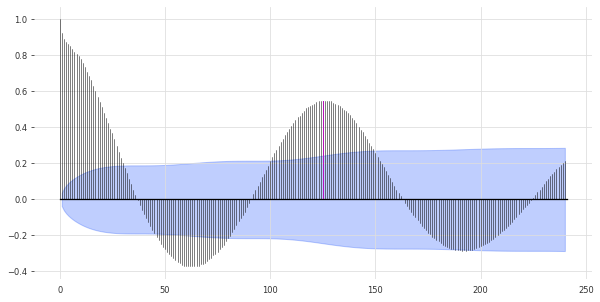

In [ ]:
# plot_acf(series_sunspot, 125, max_lag=240)  # ~11 years seasonality

In [ ]:
# train_sp, val_sp = series_sunspot.split_after(pd.Timestamp("19401001"))

# transformer_sunspot = Scaler()
# train_sp_transformed = transformer_sunspot.fit_transform(train_sp)
# val_sp_transformed = transformer_sunspot.transform(val_sp)
# series_sp_transformed = transformer_sunspot.transform(series_sunspot)

In [ ]:
# my_model_sun = BlockRNNModel(
#     model="GRU",
#     input_chunk_length=125,
#     output_chunk_length=36,
#     hidden_dim=10,
#     n_rnn_layers=1,
#     batch_size=32,
#     n_epochs=100,
#     dropout=0.1,
#     model_name="sun_GRU",
#     nr_epochs_val_period=1,
#     optimizer_kwargs={"lr": 1e-3},
#     log_tensorboard=True,
#     random_state=42,
#     force_reset=True,
# )

# my_model_sun.fit(train_sp_transformed, val_series=val_sp_transformed, verbose=True)

  0%|          | 0/100 [00:00<?, ?it/s]

To evaluate our model, we will simulate historic forecasting with a forecasting horizon of 3 years across the validation set. To speed things up, we will only look at every 10th forecast. For the sake of comparison, let's also fit an exponential smoothing model.

In [ ]:
x
#     verbose=True,
# )

# pred_series_ets = ExponentialSmoothing(seasonal_periods=120).historical_forecasts(
#     series_sp_transformed,
#     start=pd.Timestamp("19401001"),
#     forecast_horizon=36,
#     stride=10,
#     retrain=True,
#     last_points_only=True,
#     verbose=True,
# )

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

RNN MAPE: 71.86777453068686
ETS MAPE: 116.63591326597222


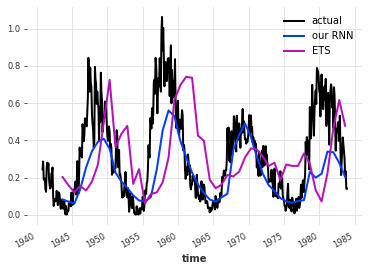

In [ ]:
# val_sp_transformed.plot(label="actual")
# pred_series.plot(label="our RNN")
# pred_series_ets.plot(label="ETS")
# plt.legend()
# print("RNN MAPE:", mape(pred_series, val_sp_transformed))
# print("ETS MAPE:", mape(pred_series_ets, val_sp_transformed))

In [ ]:
####nhits
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

from darts import TimeSeries

import tensorflow as tf
tf.compat.v1.enable_eager_execution()

from tensorflow.keras.layers import MaxPool1D

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline


In [ ]:
from darts import TimeSeries
from datetime import datetime

# Read a pandas DataFrame
df = pd.read_csv('/content/drive/MyDrive/따릉이/data/train.csv')
df['일시'] = df.일시.apply(lambda x: datetime.strptime(str(x),'%Y%m%d'))
#df.set_index('일시',inplace=True)
# Create a TimeSeries, specifying the time and value columns
series = TimeSeries.from_dataframe(df, "일시", ["광진구","동대문구","성동구","중랑구"])

# Set aside the last 36 months as a validation series
train, val = series[:1096], series[1096:]
## Read data:
#series = AirPassengersDataset().load()

## Create training and validation sets:
#train, val = series.split_after(pd.Timestamp("19590101"))

# Normalize the time series (note: we avoid fitting the transformer on the validation set)
transformer = Scaler()
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
series_transformed = transformer.transform(series)

# create month and year covariate series
year_series = datetime_attribute_timeseries(
    pd.date_range(start=series.start_time(), freq=series.freq_str, periods=1795),
    attribute="year",
    one_hot=False,
)
year_series = Scaler().fit_transform(year_series)
month_series = datetime_attribute_timeseries(
    year_series, attribute="month", one_hot=True
)
covariates = year_series.stack(month_series)
cov_train, cov_val = covariates.split_after(pd.Timestamp("2020-12-31"))

In [ ]:
from darts.models import NHiTSModel
from darts.dataprocessing.transformers import Scaler
from darts.metrics import mae
train_scaler = Scaler()
scaled_train = train_scaler.fit_transform(train)

nhits = NHiTSModel(
    input_chunk_length=168, 
    output_chunk_length=24,
    random_state=42)

nhits.fit(
    scaled_train,
    epochs=300)

scaled_pred_nhits = nhits.predict(n=699)
pred_nhits = train_scaler.inverse_transform(scaled_pred_nhits)

mae_nhits = mae(val, pred_nhits)

print(mae_nhits)

SyntaxError: ignored

In [ ]:
mae_nhits = mae(val, pred_nhits)

print(mae_nhits)

2.8774471961550043


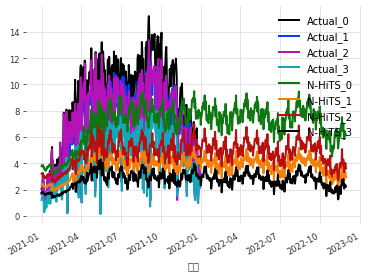

In [ ]:
val.plot(label='Actual')
pred_nhits.plot(label='N-HiTS')

In [ ]:
last_pred=pred_nhits[365:699]#2022년1월1일 2022년 11월30일
last_pred=last_pred.pd_dataframe() # 데이터프레임 변환
last_pred=last_pred.applymap(lambda x: 0 if x < 0 else x).reset_index() # -값 0으로 치환

In [ ]:
last_pred.광진구.max()

9.458979737222096

In [ ]:
submit = pd.read_csv('/content/drive/MyDrive/따릉이/data/sample_submission.csv')
submit.head()
submit['광진구']=last_pred.광진구
submit['동대문구']=last_pred.동대문구
submit['성동구']=last_pred.성동구
submit['중랑구']=last_pred.중랑구
submit=submit.set_index('일시')
submit.to_csv('/content/drive/MyDrive/따릉이/data/submit_test.csv')